**Overview**


*   The data used here is what we scraped from the "snscrape.ipynb" file
*   Scraping was done on local machine as Google Colab uses Python Version 3.6 as of the time this was published; snscrape only works with Pyhon 3.8 and above.



In [1]:
pip install nrclex

     |████████████████████████████████| 399kB 9.1MB/s 
  Created wheel for nrclex: filename=NRCLex-3.0.0-cp37-none-any.whl size=43310 sha256=3b0deaf9579cb53a0c2e49f287d125a690f41130e7fbd3d12af824fac0b9aee0
  Stored in directory: /root/.cache/pip/wheels/17/31/64/035a8d245b4c217aeb8e8a2702d05dc91544b9c2334db72414
Successfully built nrclex


**Importing Libraries & Modules**

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
import numpy as np
import re
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
from plotly import graph_objs as go
from google.colab import drive
""" To connect to colab using your local runtime, use the command: 
jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --NotebookApp.port_retries=0 
--notebook-dir="" --no-browser --allow-root --NotebookApp.token='' --NotebookApp.disable_check_xsrf=True --port=8888
to fire up your jupyter notebook then paste: http://localhost:8888/
on the colab url pop-up window """
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem.porter import  PorterStemmer
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer 
from scipy import sparse
from nrclex import NRCLex
import plotly.express as px
import spacy 
import networkx as nx
from itertools import combinations
from collections import defaultdict
import operator

In [3]:
#Mount the google drive folder

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
#Load the dataset

nairobi_df = pd.read_csv('/content/gdrive/My Drive/Coronavirus_Tweets/nairobi_county.csv')

#Preview the first four rows of the dataset

nairobi_df.head()

,Unnamed: 0,Unnamed: 0.1,Datetime,Text,retweets,likes
0,0,0,2020-06-06 19:28:03+00:00,Mmetukosea sana! \n\nSasa ningeenda hadi pahal...,0,2
1,1,1,2020-06-06 13:25:27+00:00,CAN'T WAIT 🥰🥰 #6thjune #BlackLivesMatter #Curf...,1,10
2,2,2,2020-06-06 13:24:27+00:00,Wakenya hawachoki na meme za Uhuru😂😂 #UhuruKen...,1,4
3,3,3,2020-06-06 13:03:01+00:00,Fellow Kenyans #uhuruspeaks #UhuruAddress http...,0,1
4,4,4,2020-06-06 13:02:49+00:00,#UhuruKenyatta Cessation of movement in Nairob...,0,2


In [5]:
#Preview the last four rows of the dataset

nairobi_df.tail()

,Unnamed: 0,Unnamed: 0.1,Datetime,Text,retweets,likes
8179,37,37,2020-05-29 06:20:25+00:00,President Uhuru Kenyatta made it clear that's ...,0,2
8180,38,38,2020-05-29 06:03:22+00:00,#Uhurustoughchoices Mlisema huyu Ni mtoto wa N...,0,0
8181,39,39,2020-05-29 05:19:20+00:00,Among other tough choices Uhuru must make is g...,3,4
8182,40,40,2020-05-27 18:59:53+00:00,Pandemic. Perforated pockets. Plunging economy...,1,6
8183,41,41,2020-05-27 18:54:16+00:00,Pandemic. Perforated pockets. Plunging economy...,26,35


### Shape of the data

In [6]:
#number of rows and columns of the data

nairobi_df.shape

(8184, 6)

In [7]:
#Checking the data types of our data

""" This is crucial for modeling tasks. e.g when solving a regression problem, we only deal with numerical data types and not categorical. """

nairobi_df.dtypes

Unnamed: 0       int64
Unnamed: 0.1     int64
Datetime        object
Text            object
retweets         int64
likes            int64
dtype: object

**Cleaning the Data**

### Dealing with missing values

In [8]:
#Checking for missing values

""" If there are missing values in the columns, we either fill or drop them from the respective columns with too many missing values that are not of significance to the modeling task.

For this case, there are no missing values to handle."""

nairobi_df.isnull().sum()

Unnamed: 0      0
Unnamed: 0.1    0
Datetime        0
Text            0
retweets        0
likes           0
dtype: int64

In [9]:
#Checking for duplicates
print(nairobi_df.duplicated().any())

True


In [10]:
#Dropping Duplicates

nairobi_df.drop_duplicates(keep=False, inplace=True)

#Confirming there are no duplicates

print(nairobi_df.duplicated().any())
print(nairobi_df.shape)

False
(4214, 6)


### Dealing with Outliers

##### We check for outliers because often times, they result into an impbalanced data for modeling. i.e too many outliers bring about a high variance to our data. High variance causes overfitting to our model.

##### A Z score is used since our dataset consists of more than 30 rows.

In [11]:
#Dealing with outliers
#
#Import stats from scipy library

from scipy import stats
num = ['retweets']
for i, col in enumerate(num):
    z = np.abs(stats.zscore(nairobi_df[col]))
print(z)

[0.14138055 0.0583916  0.0583916  ... 0.10758628 0.0583916  2.016332  ]


In [12]:
#Confirming that our outliers have been dropped from the data set

nairobi_df2 = nairobi_df[( z < 2 )]

print(f"Previous dataframe size : {nairobi_df.shape[0]}" )
print(f"New dataframe size : {nairobi_df2.shape[0]}" )

Previous dataframe size : 4214
New dataframe size : 4173


In [13]:
nairobi_df2.describe()

,Unnamed: 0,Unnamed: 0.1,retweets,likes
count,4173.000000,4173.000000,4173.000000,4173.000000
mean,1358.447160,1358.447160,0.938414,3.865564
std,1011.783419,1011.783419,2.363796,11.781585
min,0.000000,0.000000,0.000000,0.000000
25%,444.000000,444.000000,0.000000,0.000000
50%,1195.000000,1195.000000,0.000000,1.000000
75%,2241.000000,2241.000000,1.000000,3.000000
max,3298.000000,3298.000000,25.000000,202.000000


**Cleaning the Text**

In [14]:
#Map the lowering function to all column names

nairobi_df2.columns = map(str.lower, nairobi_df2.columns)

#Print the column names

for col in nairobi_df2:
    print(col)

unnamed: 0
unnamed: 0.1
datetime
text
retweets
likes


In [15]:
#Removing Whitespace from both columns and rows and converting case to lower case
#
#Converting the text column to string dtype after getting an attribute error
"""nairobi_df2['text'] = nairobi_df2['text'].astype(str)

nairobi_df2.columns = nairobi_df2.str.strip().str.replace(",").str.lower()

cat = nairobi_df2['text']

for i, c in enumerate(cat):
    nairobi_df2[cat] = nairobi_df2[c].str.strip().str.replace(",").str.lower()"""

#Make text lowercase, remove text in square brackets, remove links, remove punctuation and remove words containing numbers
import re
import string

def clean_text(text):
    text = str(text).lower()
    text = re.sub("\[.*?\]", '', text)
    text = re.sub("https?://\S+|www\.S+", '', text)
    text = re.sub("<.*?>+", '', text)
    text = re.sub("[%s]" % re.escape(string.punctuation) , '', text)
    text = re.sub("\n", '', text)
    text = re.sub("\w*\d\w*", '', text)
    return text

In [16]:
#Using a lambda function to clean the text column

nairobi_df2['text'] = nairobi_df2['text'].apply(lambda x:clean_text(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
#Preview the dataset to see changes

nairobi_df2.tail()

,unnamed: 0,unnamed: 0.1,datetime,text,retweets,likes
8178,36,36,2020-05-29 06:34:32+00:00,theres nothing like making a tough choice when...,0,0
8179,37,37,2020-05-29 06:20:25+00:00,president uhuru kenyatta made it clear thats t...,0,2
8180,38,38,2020-05-29 06:03:22+00:00,uhurustoughchoices mlisema huyu ni mtoto wa na...,0,0
8181,39,39,2020-05-29 05:19:20+00:00,among other tough choices uhuru must make is g...,3,4
8182,40,40,2020-05-27 18:59:53+00:00,pandemic perforated pockets plunging economy p...,1,6


In [18]:
#Removing Stopwords

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop = stopwords.words('english')

nairobi_df2['text_without_stopwords'] = nairobi_df2['text'].apply(lambda x: ' '.join(word for word in str(x).split() if word not in stop))#this method gives back a list of words

nairobi_df2.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,unnamed: 0,unnamed: 0.1,datetime,text,retweets,likes,text_without_stopwords
0,0,0,2020-06-06 19:28:03+00:00,mmetukosea sana sasa ningeenda hadi pahali gar...,0,2,mmetukosea sana sasa ningeenda hadi pahali gar...
1,1,1,2020-06-06 13:25:27+00:00,cant wait 🥰🥰 blacklivesmatter curfewinkenya w...,1,10,cant wait 🥰🥰 blacklivesmatter curfewinkenya wa...
2,2,2,2020-06-06 13:24:27+00:00,wakenya hawachoki na meme za uhuru😂😂 uhurukeny...,1,4,wakenya hawachoki na meme za uhuru😂😂 uhurukeny...
3,3,3,2020-06-06 13:03:01+00:00,fellow kenyans uhuruspeaks uhuruaddress,0,1,fellow kenyans uhuruspeaks uhuruaddress
4,4,4,2020-06-06 13:02:49+00:00,uhurukenyatta cessation of movement in nairobi...,0,2,uhurukenyatta cessation movement nairobi momba...


In [19]:
#Check for the maximum and minimum dates in the data

print(f" Data Available since {nairobi_df2.datetime.min()}")
print(f" Data Available upto {nairobi_df2.datetime.max()}")

 Data Available since 2020-02-16 11:30:23+00:00
 Data Available upto 2020-07-22 03:35:10+00:00


**Visualizations**

### Common Words

In [20]:
#Checking for the most common words

from collections import Counter
nairobi_df2['text_without_stopwords'] = nairobi_df2['text_without_stopwords'].apply(lambda x:str(x).split())
top = Counter([item for sublist in nairobi_df2['text_without_stopwords'] for item in sublist])
tweets = pd.DataFrame(top.most_common(51))
tweets.columns = ['common words', 'count']
tweets.style.background_gradient(cmap = 'Blues')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,common words,count
0,stay,1602
1,safe,1413
2,staysafe,1394
3,curfewinkenya,593
4,stayhome,472
5,home,365
6,us,319
7,nairobi,306
8,amp,255
9,kenya,253


### Wordcloud

In [21]:
def plot_wordcloud(text, mask=None, max_words=500, max_font_size=100, figure_size=(14.0,6.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'sasa', "wa", 'wa', 'sana', 'hadi', 'na', 'huyu', 'ni',
                      'za', 'enga', 'mtoto'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=400, 
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
d = '/content/gdrive/My Drive/Coronavirus_Tweets/'

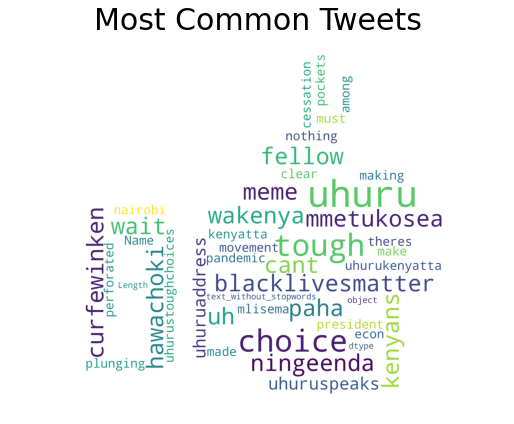

In [22]:
pos_mask = np.array(Image.open(d+ 'upvote.png'))
plot_wordcloud(nairobi_df2.text_without_stopwords,mask=pos_mask,color='white',max_font_size=300,title_size=30,title="Most Common Tweets")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



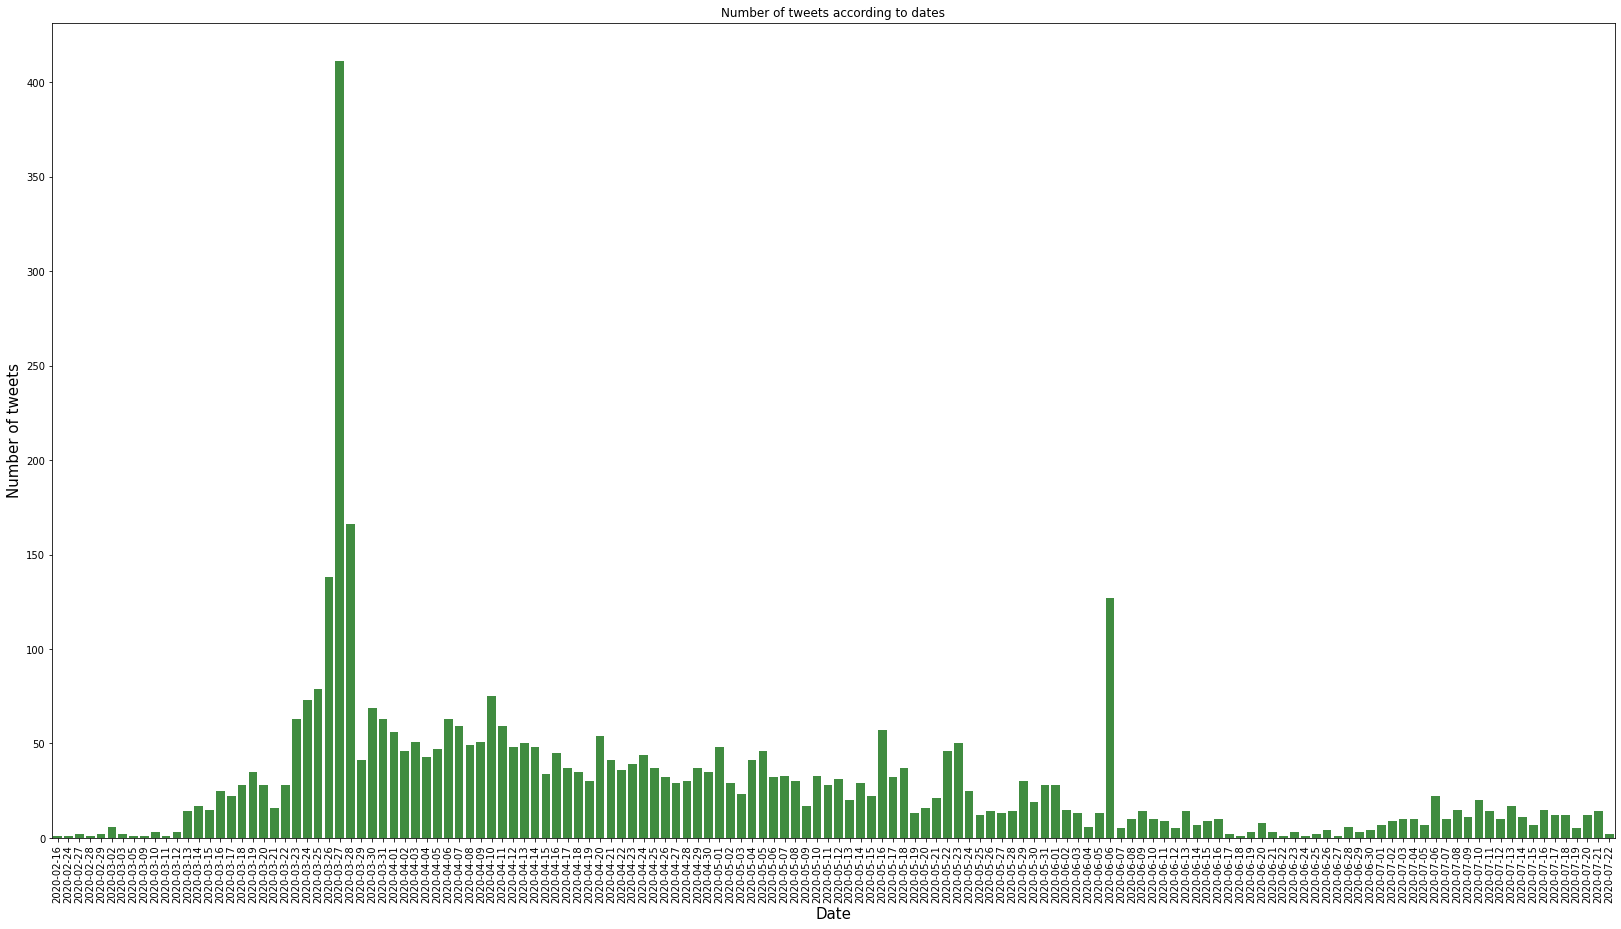

In [23]:
#The number of tweets according to dates

nairobi_df2['datetime'] =  pd.to_datetime(nairobi_df2['datetime'])
cnt_srs =nairobi_df2['datetime'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(28,15))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Number of tweets', fontsize=15)
plt.title("Number of tweets according to dates")
plt.show()

# <center>**Sentiment Analysis**</center>

#### Sentiment analysis models focus on polarity *(positive, negative, neutral)* but also on feelings and emotions *(angry, happy, sad, etc)*, urgency *(urgent, not urgent)* and even intentions *(interested v. not interested)*.

#### Considering that the goal of the project in the *project_scope.ipynb* file was to analyze the perception of Kenyan's on Coronavirus, we shall go ahead and adopt a sentiment analysis method that allows us to capture emotions and polarity of the sentiments.

#### Sentiment analysis algorithms fall into one of three buckets:


*   Rule-based: these systems automatically perform sentiment analysis based on a set of manually crafted rules.

*   Automatic: systems rely on machine learning techniques to learn from data.

*   Hybrid systems combine both rule-based and automatic approaches.

#### Given the scope of the project, I shall adopt rulr-based approach to the problem and attempt to use the automatic/Machine Learning techniques.






# <center>**Bag of Words**</center>

### Procedure


*   Tokenize
*   Remove Stopwords
*   Lemmatization
*   Modeling with BOW
*   Split test and train data





In [24]:
#Tokenizing

nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [25]:
#Save the dataframe to a csv file for Bag of Words

nairobi_df3 = nairobi_df2.to_csv('/content/gdrive/My Drive/Coronavirus_Tweets/bow.csv')

#Load the dataset
nairobi_df3 = pd.read_csv('/content/gdrive/My Drive/Coronavirus_Tweets/bow.csv')

#Preview the first few rows
nairobi_df3.head()

,Unnamed: 0,unnamed: 0,unnamed: 0.1,datetime,text,retweets,likes,text_without_stopwords
0,0,0,0,2020-06-06 19:28:03+00:00,mmetukosea sana sasa ningeenda hadi pahali gar...,0,2,"['mmetukosea', 'sana', 'sasa', 'ningeenda', 'h..."
1,1,1,1,2020-06-06 13:25:27+00:00,cant wait 🥰🥰 blacklivesmatter curfewinkenya w...,1,10,"['cant', 'wait', '🥰🥰', 'blacklivesmatter', 'cu..."
2,2,2,2,2020-06-06 13:24:27+00:00,wakenya hawachoki na meme za uhuru😂😂 uhurukeny...,1,4,"['wakenya', 'hawachoki', 'na', 'meme', 'za', '..."
3,3,3,3,2020-06-06 13:03:01+00:00,fellow kenyans uhuruspeaks uhuruaddress,0,1,"['fellow', 'kenyans', 'uhuruspeaks', 'uhuruadd..."
4,4,4,4,2020-06-06 13:02:49+00:00,uhurukenyatta cessation of movement in nairobi...,0,2,"['uhurukenyatta', 'cessation', 'movement', 'na..."


In [26]:
#Dropping the unnamed columns

nairobi_df3.drop(['Unnamed: 0', 'unnamed: 0', 'unnamed: 0.1'], axis=1)

,datetime,text,retweets,likes,text_without_stopwords
0,2020-06-06 19:28:03+00:00,mmetukosea sana sasa ningeenda hadi pahali gar...,0,2,"['mmetukosea', 'sana', 'sasa', 'ningeenda', 'h..."
1,2020-06-06 13:25:27+00:00,cant wait 🥰🥰 blacklivesmatter curfewinkenya w...,1,10,"['cant', 'wait', '🥰🥰', 'blacklivesmatter', 'cu..."
2,2020-06-06 13:24:27+00:00,wakenya hawachoki na meme za uhuru😂😂 uhurukeny...,1,4,"['wakenya', 'hawachoki', 'na', 'meme', 'za', '..."
3,2020-06-06 13:03:01+00:00,fellow kenyans uhuruspeaks uhuruaddress,0,1,"['fellow', 'kenyans', 'uhuruspeaks', 'uhuruadd..."
4,2020-06-06 13:02:49+00:00,uhurukenyatta cessation of movement in nairobi...,0,2,"['uhurukenyatta', 'cessation', 'movement', 'na..."
...,...,...,...,...,...
4168,2020-05-29 06:34:32+00:00,theres nothing like making a tough choice when...,0,0,"['theres', 'nothing', 'like', 'making', 'tough..."
4169,2020-05-29 06:20:25+00:00,president uhuru kenyatta made it clear thats t...,0,2,"['president', 'uhuru', 'kenyatta', 'made', 'cl..."
4170,2020-05-29 06:03:22+00:00,uhurustoughchoices mlisema huyu ni mtoto wa na...,0,0,"['uhurustoughchoices', 'mlisema', 'huyu', 'ni'..."
4171,2020-05-29 05:19:20+00:00,among other tough choices uhuru must make is g...,3,4,"['among', 'tough', 'choices', 'uhuru', 'must',..."


In [27]:
#Split the text column to create a new column, "text_list" then create a dataframe of two columns; "most_common_words" and "count"

nairobi_df3['text_list'] = nairobi_df3['text'].apply(lambda x:str(x).split()) #Use tokenize or split, smae results
top = Counter([item for sublist in nairobi_df3['text_list'] for item in sublist]) #Counts the frequency of words
temp = pd.DataFrame(top.most_common(6)) #top five words
temp.columns = ['common_words', 'count']
temp.style.background_gradient(cmap = 'Blues')

,common_words,count
0,the,2159
1,to,1962
2,and,1725
3,stay,1602
4,safe,1413
5,staysafe,1394


In [28]:
#Check a summary of the data

nairobi_df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4173 entries, 0 to 4172
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Unnamed: 0              4173 non-null   int64 
 1   unnamed: 0              4173 non-null   int64 
 2   unnamed: 0.1            4173 non-null   int64 
 3   datetime                4173 non-null   object
 4   text                    4173 non-null   object
 5   retweets                4173 non-null   int64 
 6   likes                   4173 non-null   int64 
 7   text_without_stopwords  4173 non-null   object
 8   text_list               4173 non-null   object
dtypes: int64(5), object(4)
memory usage: 293.5+ KB


In [29]:
#Check the Text_List column contents of first 20

nairobi_df3['text_list'][0:21]

0     [mmetukosea, sana, sasa, ningeenda, hadi, paha...
1     [cant, wait, 🥰🥰, blacklivesmatter, curfewinken...
2     [wakenya, hawachoki, na, meme, za, uhuru😂😂, uh...
3          [fellow, kenyans, uhuruspeaks, uhuruaddress]
4     [uhurukenyatta, cessation, of, movement, in, n...
5     [tumeni, pombe, ni, sahau, hiyo, kizungu, ming...
6     [maryannwanguike, forget, uhuruaddressam, a, f...
7     [nationwide, dusk, to, dawn, curfew, extended,...
8                                        [uhuruaddress]
9     [uhuru, cessation, of, movement, of, eastleigh...
10    [free, delivery, in, ongata, rongai, karen, an...
11                         [here, we, go, uhuruaddress]
12                              [lol😅, 😂, uhuruaddress]
13    [kenya, will, be, green, againissues, affectin...
14    [that, to, purchase, locally, manufactured, ve...
15    [“money, in, the, hands, of, a, family, restor...
16    [president, uhuru, kenyatta, my, administratio...
17    [the, government, need, to, add, mind, you

In [30]:
#Check the length of the text_list column

len(nairobi_df3['text_list'])

4173

**Lemmatization & Stemming**

#### English Language stemmers: only identify with English language text


1.   Porter Stemmer; uses sufix stripping. does not keep a look-up table/dictionary for words
2.   Snowball Stemmer; more agressive than porter stemmer. **NB:** *You must specify that you want the english language texts coz it also has a dictionary of other words*

#### Other Language stemmers


1.   ISRI Stemmer; Arabic Language
2.   RSLP Stemmer; Portuguese Language
1.   Lancaster Stemmer - is heavy. requires good memory of computer resources.
2.   List item






In [31]:
#Preparing text for BOW: Remove stopwords & stem/Lemmatize

def prep_text(text):
  import nltk

  #Remove HTML tags
  my_text = BeautifulSoup(text, 'html.parser').get_text()

  #Tokenize words
  tokens = nltk.word_tokenize(my_text)

  #Define Stopwords
  stops = set(stopwords.words('english'))

  #Remove the stopwords
  words = [x for x in tokens if not x in stops]

  #Stemming
  stemmer = PorterStemmer()
  stemmed_words = []
  for i in range(0, len(words)):
    l2 = ' '.join([stemmer.stem(word) for word in words])
    stemmed_words.append(l2)

  #words = [nltk.SnowballStemmer('english').stem(w) for w in words]

  #Join the words back into one string separated by a space and return results
  return stemmed_words

In [32]:
#Performing iterative preps on each of the statements
nairobi_df3['text_stem'] = nairobi_df3['text'].apply(prep_text)

In [33]:
#View the stemmed words
nairobi_df3.sample(6)

,Unnamed: 0,unnamed: 0,unnamed: 0.1,datetime,text,retweets,likes,text_without_stopwords,text_list,text_stem
2395,6388,1545,1545,2020-04-21 12:24:28+00:00,player profilefaina jacobsposition defenderstr...,1,13,"['player', 'profilefaina', 'jacobsposition', '...","[player, profilefaina, jacobsposition, defende...",[player profilefaina jacobsposit defenderstren...
3310,7308,2465,2465,2020-04-01 18:15:06+00:00,tough times dont last forever we shall overcom...,0,0,"['tough', 'times', 'dont', 'last', 'forever', ...","[tough, times, dont, last, forever, we, shall,...",[tough time dont last forev shall overcom 🙏🙏 s...
862,4848,5,5,2020-07-21 12:38:28+00:00,just because we are staying at home doesn’t me...,0,0,"['staying', 'home', 'doesn’t', 'mean', 'can’t'...","[just, because, we, are, staying, at, home, do...",[stay home ’ mean ’ look feel good shop new cl...
2336,6329,1486,1486,2020-04-23 08:17:02+00:00,🔸content marketing is important to any busines...,1,1,"['🔸content', 'marketing', 'important', 'busine...","[🔸content, marketing, is, important, to, any, ...",[🔸content market import busi want grow learn t...
3227,7223,2380,2380,2020-04-03 13:10:28+00:00,stay safe guys nairobi in nairobi,0,0,"['stay', 'safe', 'guys', 'nairobi', 'nairobi']","[stay, safe, guys, nairobi, in, nairobi]","[stay safe guy nairobi nairobi, stay safe guy ..."
3402,7402,2559,2559,2020-03-31 03:03:30+00:00,majimajikenya suewakuria njengaracheal masha...,0,1,"['majimajikenya', 'suewakuria', 'njengaracheal...","[majimajikenya, suewakuria, njengaracheal, mas...",[majimajikenya suewakuria njengarach mashaadx ...


In [34]:
#Dropping the unnamed columns

nairobi_df3.drop(['Unnamed: 0', 'unnamed: 0', 'unnamed: 0.1'], axis=1)


,datetime,text,retweets,likes,text_without_stopwords,text_list,text_stem
0,2020-06-06 19:28:03+00:00,mmetukosea sana sasa ningeenda hadi pahali gar...,0,2,"['mmetukosea', 'sana', 'sasa', 'ningeenda', 'h...","[mmetukosea, sana, sasa, ningeenda, hadi, paha...",[mmetukosea sana sasa ningeenda hadi pahali ga...
1,2020-06-06 13:25:27+00:00,cant wait 🥰🥰 blacklivesmatter curfewinkenya w...,1,10,"['cant', 'wait', '🥰🥰', 'blacklivesmatter', 'cu...","[cant, wait, 🥰🥰, blacklivesmatter, curfewinken...",[cant wait 🥰🥰 blacklivesmatt curfewinkenya wan...
2,2020-06-06 13:24:27+00:00,wakenya hawachoki na meme za uhuru😂😂 uhurukeny...,1,4,"['wakenya', 'hawachoki', 'na', 'meme', 'za', '...","[wakenya, hawachoki, na, meme, za, uhuru😂😂, uh...",[wakenya hawachoki na meme za uhuru😂😂 uhuruken...
3,2020-06-06 13:03:01+00:00,fellow kenyans uhuruspeaks uhuruaddress,0,1,"['fellow', 'kenyans', 'uhuruspeaks', 'uhuruadd...","[fellow, kenyans, uhuruspeaks, uhuruaddress]","[fellow kenyan uhuruspeak uhuruaddress, fellow..."
4,2020-06-06 13:02:49+00:00,uhurukenyatta cessation of movement in nairobi...,0,2,"['uhurukenyatta', 'cessation', 'movement', 'na...","[uhurukenyatta, cessation, of, movement, in, n...",[uhurukenyatta cessat movement nairobi mombasa...
...,...,...,...,...,...,...,...
4168,2020-05-29 06:34:32+00:00,theres nothing like making a tough choice when...,0,0,"['theres', 'nothing', 'like', 'making', 'tough...","[theres, nothing, like, making, a, tough, choi...",[there noth like make tough choic come open ec...
4169,2020-05-29 06:20:25+00:00,president uhuru kenyatta made it clear thats t...,0,2,"['president', 'uhuru', 'kenyatta', 'made', 'cl...","[president, uhuru, kenyatta, made, it, clear, ...",[presid uhuru kenyatta made clear that engag c...
4170,2020-05-29 06:03:22+00:00,uhurustoughchoices mlisema huyu ni mtoto wa na...,0,0,"['uhurustoughchoices', 'mlisema', 'huyu', 'ni'...","[uhurustoughchoices, mlisema, huyu, ni, mtoto,...",[uhurustoughchoic mlisema huyu ni mtoto wa nan...
4171,2020-05-29 05:19:20+00:00,among other tough choices uhuru must make is g...,3,4,"['among', 'tough', 'choices', 'uhuru', 'must',...","[among, other, tough, choices, uhuru, must, ma...",[among tough choic uhuru must make get compet ...


In [35]:
#Display the most common words after stemming

nairobi_df3['text_stem'] = nairobi_df3['text_stem'].apply(lambda x:str(x).split()) #Use tokenize or split, smae results
top = Counter([item for sublist in nairobi_df3['text_stem'] for item in sublist]) #Counts the frequency of words
temp = pd.DataFrame(top.most_common(21)) #top twenty words
temp.columns = ['common_words', 'count']
temp.style.background_gradient(cmap = 'Blues')

,common_words,count
0,stay,20410
1,safe,15923
2,staysaf,14571
3,stayhom,6393
4,us,5988
5,’,5824
6,home,5739
7,amp,5348
8,"staysaf',",5111
9,curfewinkenya,4516


**Analysis of the Emotions**

#### In the cells below, I carried out sentiment analysis of the tweeted content using NRCLexicons.

#### **NB:** *The context in which the analysis is taking place is during the first year of the Coronavirus pandemic in Kenya.* This is important in interpreting the results and explaining the outcome/findings.

In [36]:
#Convert the text_stem column to string type. nrclext only takes input of type str

nairobi_df3['text_stem'] = nairobi_df3['text_stem'].astype(str)

#Create a text object
text_object = NRCLex(' '.join(nairobi_df3['text_stem']))

#List emotional affect frequencies

text_object.affect_frequencies

{'anger': 0.005542186246627288,
 'anticip': 0.0,
 'anticipation': 0.028658936775322687,
 'disgust': 0.002916940129803836,
 'fear': 0.012324072048421206,
 'joy': 0.2923503245095894,
 'negative': 0.011376066506234959,
 'positive': 0.3291766936483629,
 'sadness': 0.002187705097352877,
 'surprise': 0.003646175162254795,
 'trust': 0.31182089987603007}

In [37]:
#Display the top emotions

text_object.top_emotions

[('positive', 0.3291766936483629)]

In [38]:
#Create a list from the  text object

sentiment_scores = pd.DataFrame(list(text_object.raw_emotion_scores.items())) 

#Create a dataframe of two columns

sentiment_scores = sentiment_scores.rename(columns={0: "Sentiment", 1: "Count"})
sentiment_scores

,Sentiment,Count
0,positive,4514
1,anticipation,393
2,joy,4009
3,trust,4276
4,anger,76
5,fear,169
6,negative,156
7,sadness,30
8,surprise,50
9,disgust,40


In [39]:
sentiment = sentiment_scores['Sentiment'].to_list()
sentiment

['positive',
 'anticipation',
 'joy',
 'trust',
 'anger',
 'fear',
 'negative',
 'sadness',
 'surprise',
 'disgust']

In [40]:
#A Pie Chart of the sentiment sentiment_scores

fig = px.pie(sentiment_scores, values='Count', names='Sentiment',
             title='Sentiment Scores',
             hover_data=['Sentiment'])
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

**Findings-Discussion**

##### Most of the words used suggests that Kenyan's are positive about the virus outbreak and circumstances surrounding it. However, this is also a downsie of using Lexicons. For instance:


*   "Govern" is classified as positive and trust when in reality, majority of the Kenyan's were not pleased by government directives at the time and did not have faith in how the government was managing the whole process.

*   "Church" is classified as positive, anticipation and joy. In reality, at the time, people felt their religious rights were being curtailed when any forms of religious gatherings were banned.

*   'Extend' classified as positive though we know it refers to the extension of curfew hours/days which majority of Kenyans are opposed to.

These few examples explain why it is important to understand the context in which the words were used when conducting an analysis using Lexicons.

##### More advanced processing techniques can be used, and new rules added to support new expressions and vocabulary. However, adding new rules may affect previous results, and the whole system can get very complex. 





In [41]:
#Create a dataframe with a dictionary of the sentiments

sentiment_words = pd.DataFrame(list(text_object.affect_dict.items()),columns = ['words','sentiments'])
sentiment_words

,words,sentiments
0,extend,[positive]
1,gradual,[anticipation]
2,freedom,"[joy, positive, trust]"
3,top,"[anticipation, positive, trust]"
4,protect,[positive]
...,...,...
56,employ,[trust]
57,shame,"[disgust, fear, negative, sadness]"
58,idiot,"[disgust, negative]"
59,impress,[positive]


In [42]:
for y in sentiment:
    sentiment_words[y] = 9
sentiment_words

,words,sentiments,positive,anticipation,joy,trust,anger,fear,negative,sadness,surprise,disgust
0,extend,[positive],9,9,9,9,9,9,9,9,9,9
1,gradual,[anticipation],9,9,9,9,9,9,9,9,9,9
2,freedom,"[joy, positive, trust]",9,9,9,9,9,9,9,9,9,9
3,top,"[anticipation, positive, trust]",9,9,9,9,9,9,9,9,9,9
4,protect,[positive],9,9,9,9,9,9,9,9,9,9
...,...,...,...,...,...,...,...,...,...,...,...,...
56,employ,[trust],9,9,9,9,9,9,9,9,9,9
57,shame,"[disgust, fear, negative, sadness]",9,9,9,9,9,9,9,9,9,9
58,idiot,"[disgust, negative]",9,9,9,9,9,9,9,9,9,9
59,impress,[positive],9,9,9,9,9,9,9,9,9,9


In [43]:
a=0
for i in sentiment_words['sentiments']: 
    for y in sentiment:
        sentiment_words[y][a] = int(y in i)
    a=a+1

sentiment_words.tail(11)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,words,sentiments,positive,anticipation,joy,trust,anger,fear,negative,sadness,surprise,disgust
50,friend,"[joy, positive, trust]",1,0,1,1,0,0,0,0,0,0
51,hero,"[anticipation, joy, positive, surprise, trust]",1,1,1,1,0,0,0,0,1,0
52,cheer,"[anticipation, joy, positive, surprise, trust]",1,1,1,1,0,0,0,0,1,0
53,contact,[positive],1,0,0,0,0,0,0,0,0,0
54,guard,"[fear, positive, trust]",1,0,0,1,0,1,0,0,0,0
55,comfort,"[anticipation, joy, positive, trust]",1,1,1,1,0,0,0,0,0,0
56,employ,[trust],0,0,0,1,0,0,0,0,0,0
57,shame,"[disgust, fear, negative, sadness]",0,0,0,0,0,1,1,1,0,1
58,idiot,"[disgust, negative]",0,0,0,0,0,0,1,0,0,1
59,impress,[positive],1,0,0,0,0,0,0,0,0,0


**Entity Recognition**

In [44]:
nairobi_df3.head()

,Unnamed: 0,unnamed: 0,unnamed: 0.1,datetime,text,retweets,likes,text_without_stopwords,text_list,text_stem
0,0,0,0,2020-06-06 19:28:03+00:00,mmetukosea sana sasa ningeenda hadi pahali gar...,0,2,"['mmetukosea', 'sana', 'sasa', 'ningeenda', 'h...","[mmetukosea, sana, sasa, ningeenda, hadi, paha...","[""['mmetukosea"", 'sana', 'sasa', 'ningeenda', ..."
1,1,1,1,2020-06-06 13:25:27+00:00,cant wait 🥰🥰 blacklivesmatter curfewinkenya w...,1,10,"['cant', 'wait', '🥰🥰', 'blacklivesmatter', 'cu...","[cant, wait, 🥰🥰, blacklivesmatter, curfewinken...","[""['cant"", 'wait', '🥰🥰', 'blacklivesmatt', 'cu..."
2,2,2,2,2020-06-06 13:24:27+00:00,wakenya hawachoki na meme za uhuru😂😂 uhurukeny...,1,4,"['wakenya', 'hawachoki', 'na', 'meme', 'za', '...","[wakenya, hawachoki, na, meme, za, uhuru😂😂, uh...","[""['wakenya"", 'hawachoki', 'na', 'meme', 'za',..."
3,3,3,3,2020-06-06 13:03:01+00:00,fellow kenyans uhuruspeaks uhuruaddress,0,1,"['fellow', 'kenyans', 'uhuruspeaks', 'uhuruadd...","[fellow, kenyans, uhuruspeaks, uhuruaddress]","[""['fellow"", 'kenyan', 'uhuruspeak', ""uhuruadd..."
4,4,4,4,2020-06-06 13:02:49+00:00,uhurukenyatta cessation of movement in nairobi...,0,2,"['uhurukenyatta', 'cessation', 'movement', 'na...","[uhurukenyatta, cessation, of, movement, in, n...","[""['uhurukenyatta"", 'cessat', 'movement', 'nai..."


In [45]:
#Dropping the unnamed columns

nairobi_df3.drop(['Unnamed: 0', 'Unnamed: 0', 'unnamed: 0.1'], axis=1)


,unnamed: 0,datetime,text,retweets,likes,text_without_stopwords,text_list,text_stem
0,0,2020-06-06 19:28:03+00:00,mmetukosea sana sasa ningeenda hadi pahali gar...,0,2,"['mmetukosea', 'sana', 'sasa', 'ningeenda', 'h...","[mmetukosea, sana, sasa, ningeenda, hadi, paha...","[""['mmetukosea"", 'sana', 'sasa', 'ningeenda', ..."
1,1,2020-06-06 13:25:27+00:00,cant wait 🥰🥰 blacklivesmatter curfewinkenya w...,1,10,"['cant', 'wait', '🥰🥰', 'blacklivesmatter', 'cu...","[cant, wait, 🥰🥰, blacklivesmatter, curfewinken...","[""['cant"", 'wait', '🥰🥰', 'blacklivesmatt', 'cu..."
2,2,2020-06-06 13:24:27+00:00,wakenya hawachoki na meme za uhuru😂😂 uhurukeny...,1,4,"['wakenya', 'hawachoki', 'na', 'meme', 'za', '...","[wakenya, hawachoki, na, meme, za, uhuru😂😂, uh...","[""['wakenya"", 'hawachoki', 'na', 'meme', 'za',..."
3,3,2020-06-06 13:03:01+00:00,fellow kenyans uhuruspeaks uhuruaddress,0,1,"['fellow', 'kenyans', 'uhuruspeaks', 'uhuruadd...","[fellow, kenyans, uhuruspeaks, uhuruaddress]","[""['fellow"", 'kenyan', 'uhuruspeak', ""uhuruadd..."
4,4,2020-06-06 13:02:49+00:00,uhurukenyatta cessation of movement in nairobi...,0,2,"['uhurukenyatta', 'cessation', 'movement', 'na...","[uhurukenyatta, cessation, of, movement, in, n...","[""['uhurukenyatta"", 'cessat', 'movement', 'nai..."
...,...,...,...,...,...,...,...,...
4168,36,2020-05-29 06:34:32+00:00,theres nothing like making a tough choice when...,0,0,"['theres', 'nothing', 'like', 'making', 'tough...","[theres, nothing, like, making, a, tough, choi...","[""['there"", 'noth', 'like', 'make', 'tough', '..."
4169,37,2020-05-29 06:20:25+00:00,president uhuru kenyatta made it clear thats t...,0,2,"['president', 'uhuru', 'kenyatta', 'made', 'cl...","[president, uhuru, kenyatta, made, it, clear, ...","[""['presid"", 'uhuru', 'kenyatta', 'made', 'cle..."
4170,38,2020-05-29 06:03:22+00:00,uhurustoughchoices mlisema huyu ni mtoto wa na...,0,0,"['uhurustoughchoices', 'mlisema', 'huyu', 'ni'...","[uhurustoughchoices, mlisema, huyu, ni, mtoto,...","[""['uhurustoughchoic"", 'mlisema', 'huyu', 'ni'..."
4171,39,2020-05-29 05:19:20+00:00,among other tough choices uhuru must make is g...,3,4,"['among', 'tough', 'choices', 'uhuru', 'must',...","[among, other, tough, choices, uhuru, must, ma...","[""['among"", 'tough', 'choic', 'uhuru', 'must',..."


In [46]:
# remove duplicate claims (Not really needed since dropped already)
words = nairobi_df3.text_stem.unique()

# NER list we'll use - Perhaps could be expanded?
nlp = spacy.load('en_core_web_sm')

# intialize claim counter & lists for our entities
coocur_edges = {}

print('Number of stemmed words: ', len(words))

Number of stemmed words:  4010


In [47]:
# Lets look at the first few lines of stemmed texts, along with the ents identified

for doc in nlp.pipe(words[:5]):
    print(doc)
    print(list(doc.ents))
    print('\n')

["['mmetukosea", 'sana', 'sasa', 'ningeenda', 'hadi', 'pahali', 'gari', 'itaishia', 'mafuta', 'stuck', 'anoth', 'mkikutana', 'tafadhali', 'mkuje', 'na', 'kila', 'mtu', 'kitanda', 'yake', '’', 'treat', 'nomare', '’', 'treat', 'us', 'abunomare', "uhuruaddress',", "'mmetukosea", 'sana', 'sasa', 'ningeenda', 'hadi', 'pahali', 'gari', 'itaishia', 'mafuta', 'stuck', 'anoth', 'mkikutana', 'tafadhali', 'mkuje', 'na', 'kila', 'mtu', 'kitanda', 'yake', '’', 'treat', 'nomare', '’', 'treat', 'us', 'abunomare', "uhuruaddress',", "'mmetukosea", 'sana', 'sasa', 'ningeenda', 'hadi', 'pahali', 'gari', 'itaishia', 'mafuta', 'stuck', 'anoth', 'mkikutana', 'tafadhali', 'mkuje', 'na', 'kila', 'mtu', 'kitanda', 'yake', '’', 'treat', 'nomare', '’', 'treat', 'us', 'abunomare', "uhuruaddress',", "'mmetukosea", 'sana', 'sasa', 'ningeenda', 'hadi', 'pahali', 'gari', 'itaishia', 'mafuta', 'stuck', 'anoth', 'mkikutana', 'tafadhali', 'mkuje', 'na', 'kila', 'mtu', 'kitanda', 'yake', '’', 'treat', 'nomare', '’', 'tre

In [48]:
"""# Separating this lengthy step, and saving result as a list rather than generator
# (Size isnt too big, and saves a lot of time when reused later)

# Spacy seems to have error at 3k doc mark? 
# Related to this maybe? https://github.com/explosion/spaCy/issues/1927
# Continuing on with the first 3000 of 4010 for now ; this was attempted on my local runtime but did not work

I ran 500 records only for test purposes on entity recognition since colab
crushes when the record is too large"""

corpus = list(nlp.pipe(words[:700]))

In [49]:
# Looking at number of times each entity appears in the total corpus
# nb. ents all appear as Spacy tokens, hence needing to cast as str

all_ents = defaultdict(int)

for i, doc in enumerate(corpus):
    #print(i,doc)
    for ent in doc.ents:
        all_ents[str(ent)] += 1
        
print('Number of distinct entities: ', len(all_ents))

Number of distinct entities:  273


In [50]:
# Most popular entities

sorted_ents = sorted(all_ents.items(), key=operator.itemgetter(1), reverse=True)
sorted_ents[:20]

[("'✍🏾'", 390),
 ('nairobi', 325),
 ('yesterday', 287),
 ("'kenyan'", 267),
 ("'night'", 241),
 ('curfewinkenya', 239),
 ('kindli', 192),
 ('kenya', 143),
 ("'day'", 141),
 ('kenyan', 128),
 ('first', 127),
 ('friday', 120),
 ('komeshacorona', 119),
 ("'hour", 113),
 ('today', 111),
 ('hmanyora', 105),
 ('likoniferri', 104),
 ('mimi', 104),
 ('hygien', 100),
 ('china', 96)]

In [51]:
# Number of entities that appear at least twice

multi_ents = [x for x in sorted_ents if x[1] > 1]

print('Number of ents that appear at least twice: ', len(multi_ents))

Number of ents that appear at least twice:  259


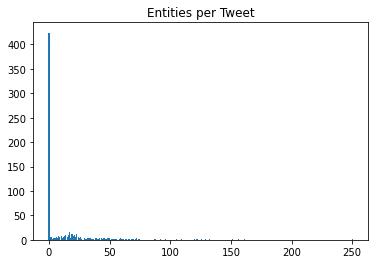

In [52]:
# How many ents appear per tweet?

ents_in_claim = [len(doc.ents) for doc in corpus]

plt.hist(ents_in_claim, 
         rwidth=0.9, 
         bins=np.arange(max(ents_in_claim)+2)-0.5)  
        # Futzing with bins just to fix column alignment - not really necessary
plt.title('Entities per Tweet')
plt.show()

In [60]:
def coocurrence(*inputs):
    com = defaultdict(int)
    
    for named_entities in inputs:
        # Build co-occurrence matrix
        for w1, w2 in combinations(sorted(named_entities), 2):
            com[w1, w2] += 1
            com[w2, w1] += 1  #Including both directions

    result = defaultdict(dict)
    for (w1, w2), count in com.items():
        if w1 != w2:
            result[w1][w2] = {'weight': count}
    return result

In [62]:
# Making the list of tweets
tweet_ents = []
for doc in corpus:
    string_ents = list(map(str, doc.ents))
    tweet_ents.append(string_ents)
    
    
# Keeping only claims with multiple entities
multi_ent_tweets = [c for c in tweet_ents if len(c)>1]
# single_ent_tweets = [c for c in tweet_ents if len(c)==1]
# no_ent_tweets = [c for c in tweet_ents if len(c)==0]


# Creating the coocurrance dict
coocur_edges = coocurrence(*multi_ent_tweets)

In [63]:
# Filter out ents with < min_weight - useful for graph clarity?

def filter_ents_by_min_weight(edges, min_weight):
    coocur_edges_filtered = defaultdict()
    for k1, e in edges.items():
        ents_over_x_weight = {k2: v for k2, v in e.items() if v['weight'] > min_weight}
        if ents_over_x_weight:  # ie. Not empty
            coocur_edges_filtered[k1] = ents_over_x_weight
    return coocur_edges_filtered

In [64]:
# Looking at the most coocurring edges

filtered_edges = filter_ents_by_min_weight(coocur_edges, 2)

coocur_sum = defaultdict(int)
for k1, e in filtered_edges.items():
    for k2, v in e.items():
        coocur_sum[k1] += v['weight']

sorted_coocur = sorted(coocur_sum.items(), key=operator.itemgetter(1), reverse=True)
print('Most frequent CO-ocurring entity:')
sorted_coocur[:20]

Most frequent CO-ocurring entity:


[("'kenyan'", 11878),
 ('nairobi', 11814),
 ('yesterday', 11350),
 ('kgachima', 10000),
 ('khamatibenard', 10000),
 ('kingethuk', 10000),
 ('koriredward', 10000),
 ('mainahaniel', 10000),
 ('moja', 8130),
 ('curfewinkenya', 7375),
 ('mimi', 6725),
 ('hmanyora', 6346),
 ("'night'", 5602),
 ('kenya', 5107),
 ('kiboko', 4898),
 ("'day'", 4736),
 ('cielewi', 4563),
 ('umeenda', 4563),
 ('wamama', 4563),
 ('kenyatta', 3981)]

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 128345 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 127997 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 129315 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 128582 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 128071 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 127873 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 128345 missing from current font.

/usr/local/lib/python3.7/dist-packages/ma

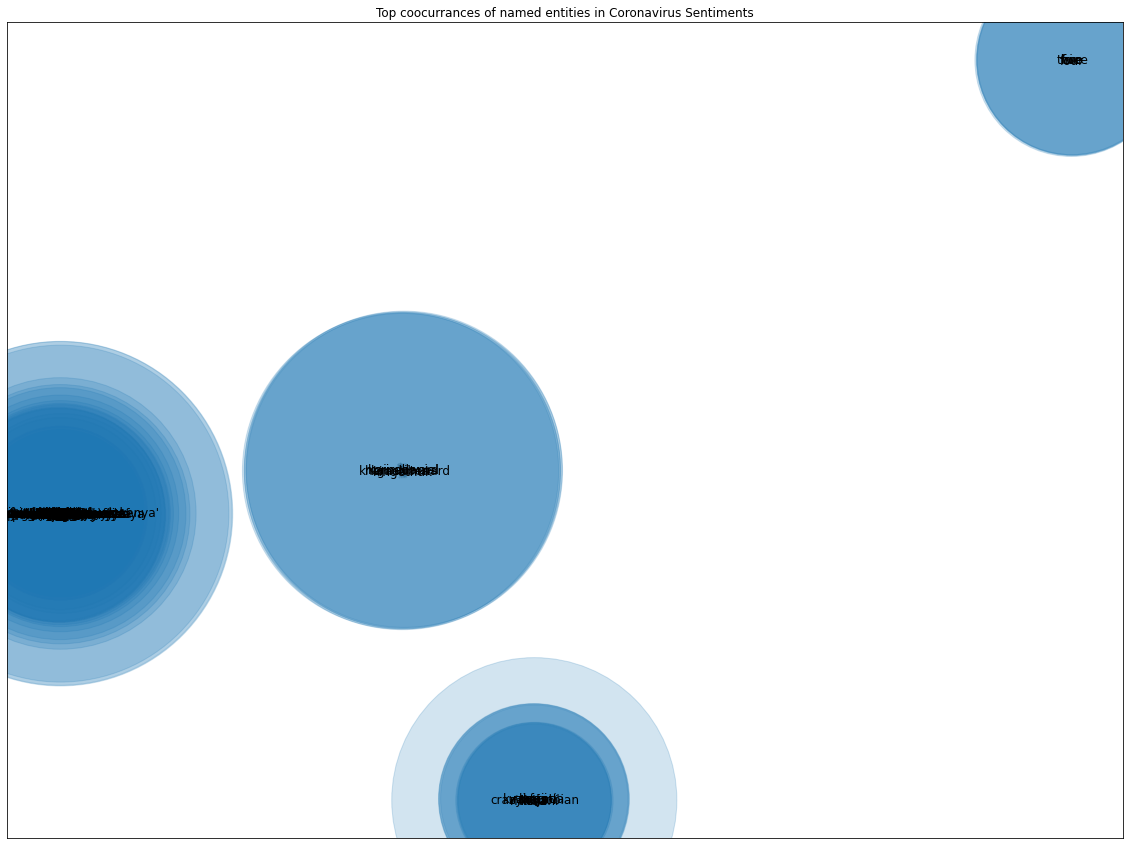

In [68]:
# Getting the data - eg top 30, including only ents with min weight 2
top_n = 30
min_weight = 2
figsize = (20, 15)
scale_nodes = lambda x: (x * 10) + 1
scale_edges = lambda x: 15 * x

filtered_edges = filter_ents_by_min_weight(coocur_edges, min_weight)

top_cooccur = [x[0] for x in sorted_coocur[:top_n]]  
graph_edges = {k:filtered_edges[k] for k in top_cooccur}

# Attempting to graph these top coocurrances
G = nx.from_dict_of_dicts(graph_edges)
pos = nx.kamada_kawai_layout(G)
# pos = nx.circular_layout(G)
# pos = nx.spring_layout(G)
# pos = nx.fruchterman_reingold_layout(G)
# pos = nx.spectral_layout(G)
# pos = nx.shell_layout(G)

# Normalise, then scale the line weights
weights = [G[u][v]['weight'] for u, v in G.edges() if u != v]
weights = list(map(lambda x: (x - min(weights)) / (max(weights) - min(weights)), weights))
weights = list(map(scale_edges, weights))

# Scale node weights 
sum_weights = [coocur_sum[n] if coocur_sum[n]>0 else 1 for n in G.nodes]
sum_weights = list(map(scale_nodes, sum_weights))
# sum_weights = list(map(lambda x: 100*log(x), sum_weights))


plt.figure(figsize=figsize)

# nx.draw(G, pos)
nx.draw_networkx_edges(G, pos, alpha=0.2, width=weights)
nx.draw_networkx_nodes(G, pos, alpha=0.2, node_size=sum_weights)
nx.draw_networkx_labels(G, pos)

plt.xticks([])
plt.yticks([])

plt.title('Top coocurrances of named entities in Coronavirus Sentiments')
plt.show()

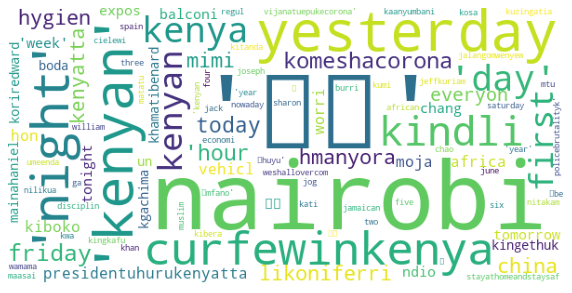

In [66]:
from wordcloud import WordCloud
from collections import Counter
from PIL import Image

# Join all the tweet entities into one list
word_list = [j for i in tweet_ents for j in i]

# Count occurences of each entity 
word_count_dict=Counter(word_list)

# Make the wordcloud - can use a black/white image for shape mask
#mask = np.array(Image.open("twitter_logo_bw.png"))
wordcloud = WordCloud(background_color="white", max_words=100, 
                      width = 600, height = 300,
                      #mask=mask, contour_width=5, contour_color="skyblue"
                     )
                      
wordcloud.generate_from_frequencies(word_count_dict)

# Show the wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Or save the file
# plt.savefig('yourfile.png', bbox_inches='tight')
# plt.close()

In [53]:
#I intend to do analyse concurrence of the entities and plot a wordcloud after this.
#Solve the problem on the size of corpus first.

**Bag of words**

In [54]:
#Vectorize the texts

"""cv = CountVectorizer

corpus = nairobi_df3['text_stem']

cv = CountVectorizer(stop_words = 'english', analyzer = 'word') #ngram_range=(2,3) groupings can be specified using ngram
bow = cv.fit_transorm(corpus)

#view the vocabulary and frequency

cv.vocabulary_"""

"cv = CountVectorizer\n\ncorpus = nairobi_df3['text_stem']\n\ncv = CountVectorizer(stop_words = 'english', analyzer = 'word') #ngram_range=(2,3) groupings can be specified using ngram\nbow = cv.fit_transorm(corpus)\n\n#view the vocabulary and frequency\n\ncv.vocabulary_"

In [55]:
#get the feature names

#cv.get_feature_names()

In [56]:
#

"""cv_sparse = cv.fit_transform(nairobi_df3['text_stem'])
col = [i for i in cv.get_feature_names()]
temp = pd.DataFrame(cv_sparse.todense(), columns = col)
temp"""

"cv_sparse = cv.fit_transform(nairobi_df3['text_stem'])\ncol = [i for i in cv.get_feature_names()]\ntemp = pd.DataFrame(cv_sparse.todense(), columns = col)\ntemp"

In [57]:
#Transform to an array

#bow.toarray()

**Resources:**


*  ##### [Text Analysis Operations using NLTK](https://www.kaggle.com/stieranka/text-analysis-operations-using-nltk)

*  ##### [Sentiment Analysis: The Simpsons](https://www.kaggle.com/ruchi798/sentiment-analysis-the-simpsons)

* #####  [Interactive Dashboards with Streamlit](https://www.analyticsvidhya.com/blog/2020/10/create-interactive-dashboards-with-streamlit-and-python/)

* #####  [Named Entity Recognition](https://www.kaggle.com/razza99/named-entity-recognition)



